In [ ]:
!pip install qiskit

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from qiskit import QuantumCircuit, transpile, assemble, Aer, IBMQ
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor
from qiskit.visualization import plot_histogram, plot_bloch_multivector
from math import gcd
import math
from numpy.random import randint
import pandas as pd
from fractions import Fraction

# **Shor's Algorithm**
---
## Contents:
1. Why is Shors Algorithm important?
2. Quantum Fourier Transform
3. Shor's Algorithm

### Authors:
Hendrik Schmidt, Tim Kapferer, Tim Petersen

# Why is Shors Algorithm important?

## Modern Cryptography:
___
To have safe data, and especially safe data transfer, there needs to be some kind of data encryption. There are two main ways to go about this: <br>
1. **Symmetric encryption** <br>
    The rather classical way of encryption, there is one key for encryption and also for decryption.
2. **Asymmetric encryption** <br>
    This variant is speical in that way, that there are two keys, a public and a private key created by a one way function.

The problem with **Symmetric encryption** is that, since there is only one key, key and data need to be exchanged via different channels and that gets quite complicated especially when communicating over the internet. <br>
The solution therefore is **Asymmetric encryption** where we can give out a key (public) which we can easily deploy everywhere and as open as we like, because it can only be used to ***encrypt*** data, but never to ***decrypt*** the data.
For this mechanism to work there exist one-way functions which are easily calculatable in one way, but extremly complex the other way around. <br> <br>

The most common used asymmetric encryption algorithm in the world is **RSA**. <br> <br>

---

## RSA (Rivest–Shamir–Adleman)
The security of RSA is based on the "factoring problem", the difficulty to factor the product of two large prime numbers. <br> <br>
Before diving into why Shors Algorithm is a thread (or a cure) for this algorithm (or rather the problem, this algorithm is based on), we take a short look on how this algorithm and the key generation works.
<br>
<br>

### Operation of RSA:
The algorithm consists of four steps:
1. key generation
2. key distribution
3. encryption
4. decryption

These steps lead to the following equation being possible:
$$ (m^e)^d ≡ m \;(mod\; n) $$


#### Key generation:
1. Choose two large prime numbers $p$ and $q$, these need to be kept secret
2. Compute $n=pq$ <br>
    n is used as modulus for the public and the private key, so this can be given out.
3. Compute $φ(n) = (p-1) (q-1)$
4. Choose an integer $e$ such that $ 1<e<φ(n)$ <br>
e is also being released as part of the public key

5. Compute $d$ by solving the equation $d ≡e^{-1} (mod\; φ(n))$ so $de ≡ 1 \;(mod\; φ(n))$

So now we have the public key consisting of $e, n$ and and the private key $d,n$

#### Key distribution:
The public key $e,n$ can now be given out to any person or any place you want to establish a safe connection with since it is close to impossible to get $d$ just by having $e$ and/or $n$. For an example we assume that A created the keys and gave the public key to B.

#### Encryption:
B having the public key can now encrypt the message he wants to send by applying the following formula: $$ c ≡ m^e \;(mod\; n) $$
$m$ being the original message, $c$ being the encrypted message, and $e$ and $n$ being the public key from before.
B can now send $c$ to A.

#### Decryption:
A can now decrypt $c$ to get back $m$ by applying: $$ c ≡ (m^e)^d ≡ m \;(mod\; n)$$
<br>
<br>

---
## Breaking the factoring problem:

To get back to the correct prime factors, given just the product, is close imposible for large enough numbers. <br>
The naive approach would be to just try dividing by every number smaler than the square root and afterwards checking for it being a prime number. This scales with a time factor of $\sqrt{2^n}$ (Here $n$ is the length of bits of the number used). There is also a better variant, that is currently used, the GNFS (General number field sieve) with a time factor of $$e^{c\sqrt[3]{ln(n)\,(ln\, ln\,n)^2   }}$$ Still with rising numbers the time needed to refactor shows a diverging behaviour and could take centuries, year-thousands or even longer than the age of the universe.
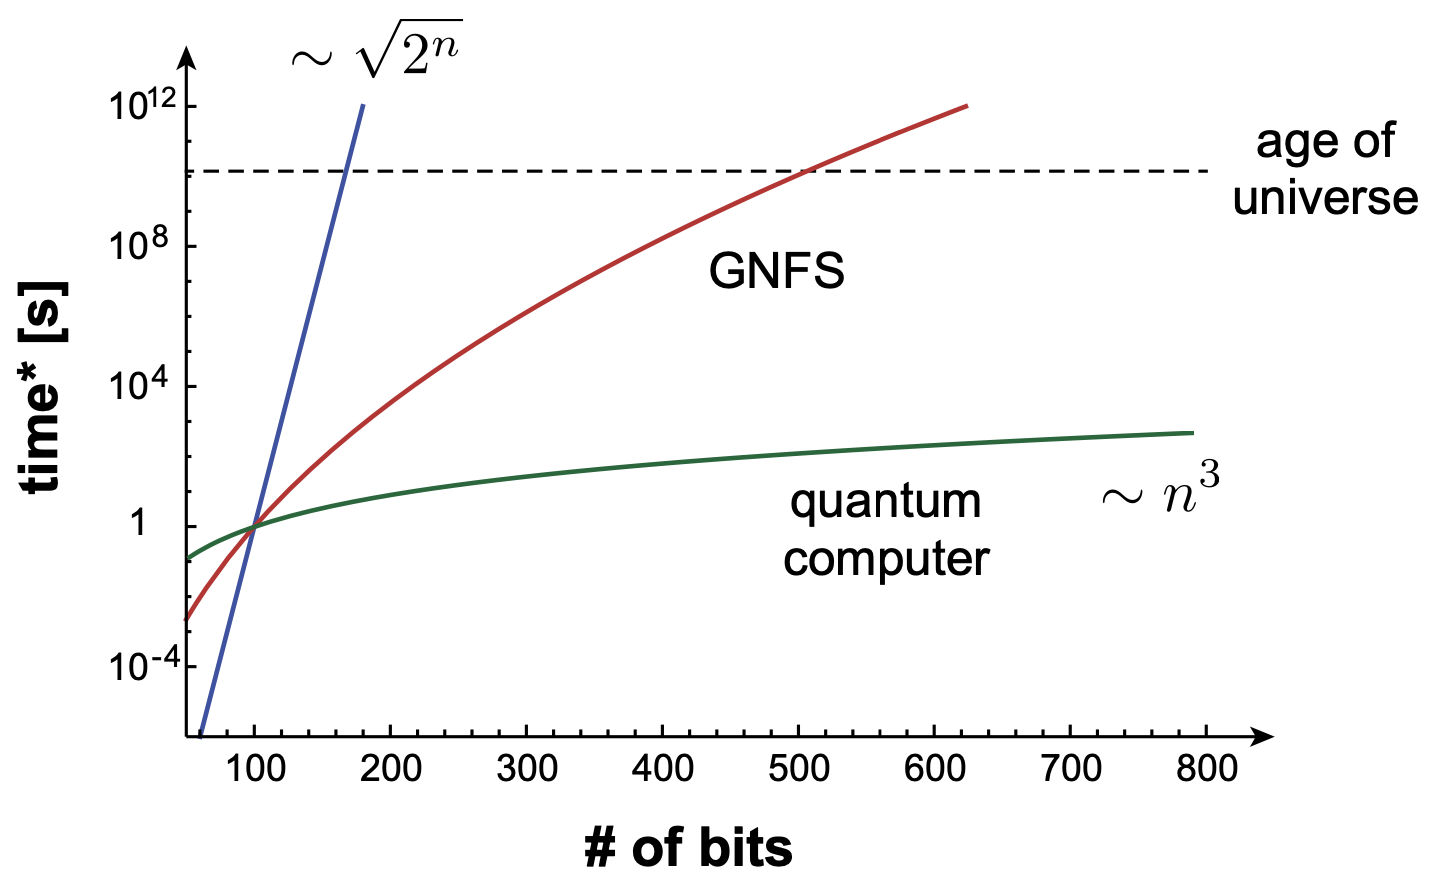
Figure 1.
This shows the time complexity of the factoring problem, depicted are the naive algorithm, GNFS and Shors Algorithm on a quantum computer. <br>
Source: [5]

<br>

---

## How Shors algorithm solves the factoring problem

The fundament for the solution in "solving" the factoring problem lies in modular arithmetic. In modular arithmetic, functions like $$ f(x) = a^x \; mod \; n$$, have periodic behaviour, meaning there is a certain period after which the numbers repeat over and over again. In the following graph we can see the example for $a$ being 3 and $n$ being 35 with $r$ (the period length) being 12


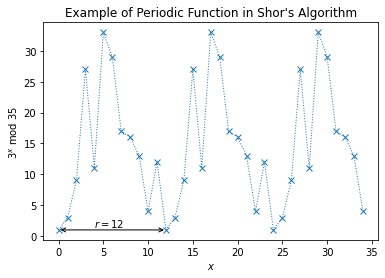

In [ ]:
#@title Example periodic function
N = 35
a = 3

# Calculate the plotting data
xvals = np.arange(35)
yvals = [np.mod(a**x, N) for x in xvals]

# Use matplotlib to display it nicely
fig, ax = plt.subplots()
ax.plot(xvals, yvals, linewidth=1, linestyle='dotted', marker='x')
ax.set(xlabel='$x$', ylabel=f'${a}^x$ mod ${N}$',
       title="Example of Periodic Function in Shor's Algorithm")
try: # plot r on the graph
    r = yvals[1:].index(1) + 1
    plt.annotate('', xy=(0,1), xytext=(r,1),
                 arrowprops=dict(arrowstyle='<->'))
    plt.annotate(f'$r={r}$', xy=(r/3,1.5))
except ValueError:
    print('Could not find period, check a < N and have no common factors.')

To understand how we can now get this qunatum-speed-up, we first need to understand the concept of quantum fourier transform.

# **Quantum Fourier Transform**

The quantum Fourier transform is a quantum algorithm that can be used to quickly perform a Fourier transform, which is a mathematical operation that decomposes a signal into its component frequencies. This is a useful operation in many different fields, including signal processing and data analysis. The quantum Fourier transform can be performed much faster than the classical Fourier transform, which makes it a valuable tool for solving certain types of problems in quantum computing.

**Classical Fourier Transform**


---



The Fourier transform is a mathematical operation that decomposes a signal into its component frequencies. This is a useful operation in many different fields, including signal processing and data analysis. The Fourier transform allows a signal to be represented as a sum of sinusoidal functions, which makes it easier to understand and manipulate the signal.

For example, suppose you have a signal that varies over time, such as a sound wave or a light wave. The Fourier transform of this signal breaks it down into its individual frequencies, which can be thought of as the "building blocks" of the signal. This allows you to see which frequencies are present in the signal and how they combine to create the overall shape of the signal.

For our pruposes, we can think of this signal as being representede by the vector v. The Fourier Transform then gives us the vector $\bar{v} = F_n v$. The Fourier Transform sometimes also gets defined for a function rather than for a vector. For our purposes though, the definition on a vector is more useful.

Mathematically, the entries of $\bar{v_j}$ are given by  $\sum_{k=0}^{N-1} w_N^{jk} v_k$. In this equation, $w_N$ is defined as $w_N = \mathrm{e}^{2 \pi i / N}$. The complex number is needed for cases that are more than two dimensional.



**The Quantum Fourier Transform**


---



The Quantum Fourier Transform implements a change of basis between the computational and the Fourier Basis. Sticking with our definition of the Fourier Transform as transforming the entries of a vector from the previous section. We can describe this change of basis as tranforming a N-dimensional vetor containing amplitudes to another N-dimnesional vector containing the transformed amplitudes. In our case, these vectors of amplitudes are quantum states. But, in difference to the Fourier Transform, applying the Quantum Fourier Transform won't provide us with the entries that the Fourier Transform provides us with, but rather with the amplitudes of the different states.


In the case of a single qubit system the Hadamard-gate is the Quantum Fourier Transform for this system. It transforms between the states $| 0 \rangle$ and $| 1 \rangle$ to the states $| + \rangle$ and $| - \rangle$. The Hadamard gate is defined as:

\begin{align}
        H = \frac{1}{\sqrt{2}}\begin{pmatrix}
        1 & 1 \\
        1 & -1
        \end{pmatrix}.
    \end{align}


To implement the circuit for multiple qubits, we will make use of the Hadamard as well as controlled rotational gates $R_s$. This gate is defined in the following way:

\begin{align}
        R_s = \begin{pmatrix}
        1 & 0 \\
        0 & \mathrm{e}^{2 \pi i / 2^s}
        \end{pmatrix}.
    \end{align}

To discover what the circuit should look like, we can derive the Quantum Fourier Transform explicitly. The following derivation is taken from Qiskits Tutorial on the Quantum Fourier Trasnform, which can be found [here](https://qiskit.org/textbook/ch-algorithms/quantum-fourier-transform.html#implementation).

$$
\begin{aligned}
QFT_N\vert x \rangle & = \frac{1}{\sqrt{N}} \sum_{y=0}^{N-1}\omega_N^{xy} \vert y \rangle
\\
& = \frac{1}{\sqrt{N}} \sum_{y=0}^{N-1} e^{2 \pi i xy / 2^n} \vert y \rangle ~\text{since}\: \omega_N^{xy} = e^{2\pi i \frac{xy}{N}} \:\text{and}\: N = 2^n
\\
& = \frac{1}{\sqrt{N}} \sum_{y=0}^{N-1} e^{2 \pi i \left(\sum_{k=1}^n y_k/2^k\right) x} \vert y_1 \ldots y_n \rangle \:\text{rewriting in fractional binary notation}\: y = y_1\ldots y_n, y/2^n = \sum_{k=1}^n y_k/2^k
\\
& = \frac{1}{\sqrt{N}} \sum_{y=0}^{N-1} \prod_{k=1}^n e^{2 \pi i x y_k/2^k } \vert y_1 \ldots y_n \rangle \:\text{after expanding the exponential of a sum to a product of exponentials}
\\
& = \frac{1}{\sqrt{N}} \bigotimes_{k=1}^n  \left(\vert0\rangle + e^{2 \pi i x /2^k } \vert1\rangle \right) \:\text{after rearranging the sum and products, and expanding}
\sum_{y=0}^{N-1} = \sum_{y_1=0}^{1}\sum_{y_2=0}^{1}\ldots\sum_{y_n=0}^{1}
\\
& = \frac{1}{\sqrt{N}}
\left(\vert0\rangle + e^{\frac{2\pi i}{2}x} \vert1\rangle\right)
\otimes
\left(\vert0\rangle + e^{\frac{2\pi i}{2^2}x} \vert1\rangle\right)
\otimes
\ldots
\otimes
\left(\vert0\rangle + e^{\frac{2\pi i}{2^{n-1}}x} \vert1\rangle\right)
\otimes
\left(\vert0\rangle + e^{\frac{2\pi i}{2^n}x} \vert1\rangle\right)
\end{aligned}
$$

What this derivation tells us, is the general approach for the circuit. We apply a Hadamard gate to the last qubit. For the second last wubit we first apply a $R_s$-gate conditioned on the last qubit before applying a Hadamard gate to this qubit as well. For any qubit after that we first apply as many $R_s$-gates as qubits that we have already seen. Any of those $R_s$-gates is only conditioned on one of the previously seen qubits. After having applied those gates, we then apply the Hadamard gate to the current qubit. We continue doing this until we have applied the Hadmard gate to the first qubit.
Once we reached the first qubit the main part of the Quantum Fourier Transform is done. What remains is a swapping of the qubits, since we applied the Quantum Fourier Transform in the wrong order. In the case of N qubits, we need to perform $N//2$ swaps.

**Implementation in Qiskit**


---



**Hadamard and rotation gates**





We first need to define a function that applies the hadamard gate to any of the qubits as well as the rotations. Since the rotations are only applied to the n-1 remaining qubits after we applied the hadamard gate to the nth qubits, this function can be easily implemented in a recursive fashion.

In [ ]:
def hadamard_rotations(n, circuit):
  # stop signal for our recursive function
  if n == 0:
    return circuit
  # we remove the count of n to move to the next qubit
  n -= 1
  # we first apply the hadamard gate to the current qubit
  circuit.h(n)
  # then we perform the rotations with the n remaining qubits
  for qubit in range(n):
    circuit.cp(math.pi/2**(n-qubit), qubit, n)
  # we apply the function recursively until we applied the hadamard gate to every qubit
  hadamard_rotations(n, circuit)

**Swapping the qubits**





After we applied the hadamard as well as the rotaion gates we need to swap the qubits. This is because we started with the nth qubit and made our way to the first qubit. To obtain the correct circuit we need to do n//2 swaps.

In [ ]:
def swap(n, circuit):
  # we iterate over the n//2 qubits that need to be swapped and swap them with their counterpart
  for qubit in range(int(n/2)):
    circuit.swap(qubit, n-1-qubit)
  return circuit

**Quantum Fourier Transform function**





Finally, we can use both of the above functions to implement the Quantum Fourier Transform.

In [ ]:
def QFT(n, circuit):
  # we first need to apply the hadamard gates as well as the rotations
  hadamard_rotations(n, circuit)
  # we then swap the qubits to obtain our final result
  swap(n, circuit)
  return circuit

**Drawing the resulting circuit**





In [ ]:
qc = QuantumCircuit(4)
QFT(4,qc)
qc.draw()

┌───┐»
q_0: ──────■───────────────────────────────■──────────────────────■───────┤ H ├»
           │                               │                ┌───┐ │P(π/2) └───┘»
q_1: ──────┼────────■──────────────────────┼────────■───────┤ H ├─■─────────X──»
           │        │                ┌───┐ │P(π/4)  │P(π/2) └───┘           │  »
q_2: ──────┼────────┼────────■───────┤ H ├─■────────■───────────────────────X──»
     ┌───┐ │P(π/8)  │P(π/4)  │P(π/2) └───┘                                     »
q_3: ┤ H ├─■────────■────────■─────────────────────────────────────────────────»
     └───┘                                                                     »
«        
«q_0: ─X─
«      │ 
«q_1: ─┼─
«      │ 
«q_2: ─┼─
«      │ 
«q_3: ─X─
«

**The Inverse Quantum Fourier Transform**








In [ ]:
def inverse_qft(n, circuit):
    # We perform a QFT on a circuit of size n
    qft_circ = QFT(n, QuantumCircuit(n))
    # Inverse the circuit
    invqft_circ = qft_circ.inverse()
    # Add it to the qubits in our existing circuit
    circuit.append(invqft_circ, circuit.qubits[:n])
    return circuit.decompose()

# **Shor's Algorithm**
---

Shor's Algorithm is a quantum algorithm for integer factorization, developed by Peter Shor in 1994. It is notable for its polynomial time complexity, meaning that it can solve the factoring problem exponentially faster than classical computers, because of the Quantum Fourier Transform speed-up.
The algorithm transforms the factoring problem into the problem of finding the period of the function $a^x=1$ (mod $N$). This allows the algorithm to efficiently factor large integers, a task that is believed to be computationally infeasible for classical computers.

**Order Finding**

As we already discussed above, the order is defined as:
> *Definition*: Let $x$ and $N$ be two positive integers with $x < N$ and $x$ co-prime to $N$. The order of $x$ mode $N$ is the least positive integer $r$ such that<br><br>
$x^r=1($mod $N$).

Two integers are co-prime if they don't have common factors, which means that the greatest common divisor (gcd) of the two integers is $1$. Note that the order $r$ is equivalent to the period $r$ with $f(x) = f(x + r)$.<br>

The general idea of the order-finding procedure is to use phase estimation.
Given a unitary operator $U$ with the eigenstate $|u⟩$ and the eigenvalues $e^{2\pi i \phi}$, where $\phi$ is unknown. The goal of the phase estimation algorithm is to determine an estimate of $\phi$.


This is the general procedure of phase estimation for finding an estimate of the period $r$:

1. Start with two registers in the initial state $|0\ldots 0⟩|0\ldots 0⟩$.
2. Apply the Hadamard gate on the first register: <br>
$$\frac{1}{\sqrt{2^t}}\sum_{k=0}^{2^t-1}|k⟩|0\ldots 0⟩$$

3. Apply the unitary operation $U$ on the second register controlled by the first register:
$$\frac{1}{\sqrt{2^t}}\sum_{k=0}^{2^t-1}|k⟩|x^k\textrm{ mod }N⟩$$
4. Take an implicit measurement of the second register.
5. Apply the inverse Fourier Transform on the first register.
6. Take a measurement of the first register.
7. Apply the continued fraction algorithm to estimate $r$.


The first register after applying the Hadamard operation on the first register and the $U$ operation on the second register can also be expressed as:
$$\frac{1}{\sqrt{2^{t}}}\sum_{k=0}^{2^t-1}e^{2\pi i \phi k}|k\rangle \textrm{ with } \phi=\frac{s}{r}$$
Note the similarity of the formula above to the formula of the Quantum Fourier Transform (QFT).
We take an implicit measurement of the second register. Since the second register consists of the binary values of the modulo function, the measurement will give us one of the values of the modulo function.
This reduces the number of values in the first register to the corresponding values of the measured modulo values of the second register. Therefore, all the remaining values $k$ in the first register are equivalent for $x^k \textrm{ mod }N$. As we already observed the similarity between the QFT and the formula above, we take the inverse of the QFT, since the inverse QFT of QFT will give us the phase. <br>
However, if we were to take the QFT instead of the inverse QFT, we would still obtain the same results, since the QFT and the inverse QFT peak if $\frac{s}{r}$ is an integer value. This is because the inverse QFT differs from the QFT with a minus in the exponent.
<br>
Later, we will go through an example step by step to clarify these steps.

**Factoring Problem**

Understanding the relation between the factoring problem and the order finding requires us to understand the following two theorems: <br>

> *Theorem 1:* Suppose $N$ is an $L$ bit composite number, and $x$ is a non-trivial solution to the equation $x^2=1($mod$ N)$ in the range $1 ≤ x ≤ N$, that is, neither
$x = 1($mod $N )$ nor $x = N − 1 = −1($mod$ N)$. Then at least one of
gcd($x − 1$,$N$) and gcd($x + 1$,$N$) is a non-trivial factor of $N$ that can be computed using $O(L^3)$ operations.

**Proof**: The formula $x^2 = 1 \textrm{ (mod } N)$ equals $(x+1)(x-1)=0 \textrm{ (mod } N)$ and therefore $(x+1)(x-1)=nN$, with $n > 0$. <br>

This means that if we can find a solution for $x^2=1 $ (mod $N$), then it is guaranteed that we are able to calculate at least one factor of $N$. If $N$ consists of only two factors, then one factor is sufficient to find the remaining factor of $N$. <br><br>
The following is an example of the theorem. We choose $p=7, q=11$, hence $N=p\times q=77$. Feel free to change the values of $p$ and $q$.


N equals:  77
Solution:  34
Solution:  43
Calculating the greatest common divors:
x + 1 =  35
Potential factor:  7
x - 1 =  33
Potential factor:  11


x + 1 =  44
Potential factor:  11
x - 1 =  42
Potential factor:  7




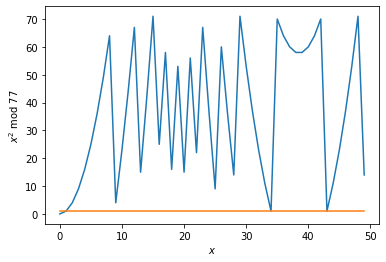

In [ ]:
#@title Example of Theorem 1
# Choose values for p and q
# Since we brute force the solution q and p should be quite small
p = 7
q = 11

# Calculate N
N = p * q
print("N equals: ", N)

# increase the values, if no solution is in the range
x = np.arange(50)

y = [(i**2) % N for i in x]

plt.plot(x,y)
plt.plot(x, np.ones(len(x)))
plt.xlabel("$x$")
plt.ylabel(f"$x^2$ mod ${N}$")

count = 0
solutions = []
for i in y:
    if i == 1 and count != 1:
        print("Solution: ", count)
        solutions.append(count)
    count += 1


print("Calculating the greatest common divors:")
for solution in solutions:
    print("x + 1 = ", solution+1)
    print("Potential factor: ", math.gcd(solution+1, N))

    print("x - 1 = ", solution-1)
    print("Potential factor: ", math.gcd(solution-1, N))
    print('\n')


The second theorem states the following:

> *Theorem 2:* Suppose $N=p_1^{\alpha_1}\ldots p_m^{\alpha_m}$ is the prime factorization of an odd composite positive integer. Let $x$ be an integer chosen uniformly at random, subject to the requirements that $1 ≤ x ≤ N − 1$ and $x$ is co-prime to $N$ . Let $r$ be the order of $x$ modulo $N$. Then<br><br>
$$p(r \textrm{ is even and } x^{r/2}\neq -1(\textrm{mod }N)) \geq 1 - \frac{1}{2^m}.$$

We can further simplify the probability because in our case $N$ consists of only two factors:

$$p(r \textrm{ is even and } x^{r/2}\neq -1(\textrm{mod }N)) \geq \frac{1}{2}.$$ <br>

- If we are able to find the period $r$, there is a high probabilty that $r$ is even, which allows to write that $y=x^{r/2}$ is a solution to the formula of the previous theorem $y^2=1\textrm{(mod }N)$ since the fraction $\frac{r}{2}$ is an integer.
- $x^{r/2}\neq -1$ (mod $N$) equals $x^{r/2}+1\neq 0$ (mod $N$), which means that $y+1$ is not a multiple of $N$ with probability greater than $0.5$.

Combining the theorems guarantees us that with at least a probability of $0.5$, we are able to find a non-trivial factor of $N$.

**Shor's Algorithm Procedure**

**Input:** Number $N$ consisting of unkown factors. <br>
**Output:** Trivial factor of $N$. <br><br>

1. Choose a random integer $a$ in the range $0 < a < N$, which is co-prime to $N$: gcd($a$, $N$) $= 1$.
2. Apply the order-finding procedure to estimate the order $r$ of the function $a^x = 1$ (mod $N$).
3. Validate that $r$ is even and that the function $a^\frac{r}{2}\ -1\neq$ (mod $N$) is fullfilled (Theorem 2).
4. Calculate $x=a^\frac{r}{2}$ (mod $N$) and compute gcd($x+1$, $N$) and gcd($x-1$, $N$) (Theorem 1). Test if the results are non-trivial factors of $N.$


If step 3 fails retry by starting from step 1.






**Implementation and Example**

In the following example, we will step-by-step apply Shor's Algorithm. As an example, we choose $N = 15$, since for larger values of $N$ the representation will get quite messy.

In [ ]:
#@title Visualization of the Quantum Circuit

# This curcuit is only for the visualization

a = 4


# Source: https://learn.qiskit.org/course/ch-algorithms/shors-algorithm
def c_amod15(a, power):
    """Controlled multiplication by a mod 15"""
    if a not in [2,4,7,8,11,13]:
        raise ValueError("'a' must be 2,4,7,8,11 or 13")
    U = QuantumCircuit(4)

    U = U.to_gate()
    U.name = f"{a}^{power} (mod 15)"
    c_U = U.control()

    return c_U

# Source: https://learn.qiskit.org/course/ch-algorithms/shors-algorithm
def qft_dagger(n):
    """n-qubit QFTdagger the first n qubits in circ"""
    qc = QuantumCircuit(n)
    # Don't forget the Swaps!
    for qubit in range(n//2):
        qc.swap(qubit, n-qubit-1)
    for j in range(n):
        for m in range(j):
            qc.cp(-np.pi/float(2**(j-m)), m, j)
        qc.h(j)
    qc.name = "QFT†"
    return qc

circuit = QuantumCircuit(8, 8)

circuit.barrier()


# Hadamard operation on the first register
circuit.h(range(4))

circuit.barrier()

circuit.append(c_amod15(a, 8),[0,4,5,6,7])
circuit.append(c_amod15(a, 4),[1,4,5,6,7])
circuit.append(c_amod15(a, 2),[2,4,5,6,7])
circuit.append(c_amod15(a, 1),[3,4,5,6,7])

circuit.barrier()

circuit.measure(range(4,8), range(4,8))

circuit.barrier()

# Do inverse-QFT
circuit.append(qft_dagger(4), range(4))

circuit.barrier()


circuit.measure(range(4), range(4))

circuit.barrier()
circuit.draw(fold=-1)



░ ┌───┐ ░                                                                      ░              ░ ┌───────┐ ░ ┌─┐          ░ 
q_0: ─░─┤ H ├─░─────────■────────────────────────────────────────────────────────────░──────────────░─┤0      ├─░─┤M├──────────░─
      ░ ├───┤ ░         │                                                            ░              ░ │       │ ░ └╥┘┌─┐       ░ 
q_1: ─░─┤ H ├─░─────────┼────────────────■───────────────────────────────────────────░──────────────░─┤1      ├─░──╫─┤M├───────░─
      ░ ├───┤ ░         │                │                                           ░              ░ │  QFT† │ ░  ║ └╥┘┌─┐    ░ 
q_2: ─░─┤ H ├─░─────────┼────────────────┼────────────────■──────────────────────────░──────────────░─┤2      ├─░──╫──╫─┤M├────░─
      ░ ├───┤ ░         │                │                │                          ░              ░ │       │ ░  ║  ║ └╥┘┌─┐ ░ 
q_3: ─░─┤ H ├─░─────────┼────────────────┼────────────────┼────────────────■─────────░──────────────░─┤3      ├─░──╫──╫──╫─┤M├─░─
      ░ └───┘ ░ ┌───────┴───────┐┌───────┴───────┐┌───────┴───────┐┌───────┴───────┐ ░ ┌─┐          ░ └───────┘ ░  ║  ║  ║ └╥┘ ░ 
q_4: ─░───────░─┤0              ├┤0              ├┤0              ├┤0              ├─░─┤M├──────────░───────────░──╫──╫──╫──╫──░─
      ░       ░ │               ││               ││               ││               │ ░ └╥┘┌─┐       ░           ░  ║  ║  ║  ║  ░ 
q_5: ─░───────░─┤1              ├┤1              ├┤1              ├┤1              ├─░──╫─┤M├───────░───────────░──╫──╫──╫──╫──░─
      ░       ░ │  4^8 (mod 15) ││  4^4 (mod 15) ││  4^2 (mod 15) ││  4^1 (mod 15) │ ░  ║ └╥┘┌─┐    ░           ░  ║  ║  ║  ║  ░ 
q_6: ─░───────░─┤2              ├┤2              ├┤2              ├┤2              ├─░──╫──╫─┤M├────░───────────░──╫──╫──╫──╫──░─
      ░       ░ │               ││               ││               ││               │ ░  ║  ║ └╥┘┌─┐ ░           ░  ║  ║  ║  ║  ░ 
q_7: ─░───────░─┤3              ├┤3              ├┤3              ├┤3              ├─░──╫──╫──╫─┤M├─░───────────░──╫──╫──╫──╫──░─
      ░       ░ └───────────────┘└───────────────┘└───────────────┘└───────────────┘ ░  ║  ║  ║ └╥┘ ░           ░  ║  ║  ║  ║  ░ 
c: 8/═══════════════════════════════════════════════════════════════════════════════════╩══╩══╩══╩═════════════════╩══╩══╩══╩════
                                                                                        4  5  6  7                 0  1  2  3

We represented the steps of the example by the punctured verticle lines in the circuit.

**Step 1: The inital states**

The qubits of both register are initialized with $0$: $|0\ldots 0⟩|0\ldots 0⟩$
- The number of qubits in the first register determines the accuracy of $r$ and the success probability of the estimation.
- The second register requires as many qubits as necessary to store $N$

The binary representation of $15$ is $1111$, therefore the second register requires four qubits. For the first register we will also choose four qubits:
 $$|\psi⟩_{in}=|0000⟩|0000⟩$$

We also need to choose an integer $a$, which is co-prime with $N$:
$$a=4$$

In [ ]:
if math.gcd(4, 15) == 1:
    print("It's co-prime!")

It's co-prime!


**Step 2: Application of the Hadamard gate**

Now we need to apply the Hadamard gate to the first register to bring the qubits into the superposition:
$$|\bar{\psi}⟩=(H^{\otimes l}⊗\mathbb{1}_n)|\psi ⟩_{in}=\frac{1}{\sqrt{L}}\sum_{j=0}^{L-1}|j⟩|0\ldots0⟩$$
- The identity $\mathbb{1}$ denotes that the second register stays the same.
- $L = 2^l$.
- Binary representation: $|j⟩=|j_1j_2j_3\ldots j_{l}$⟩.

For our example it looks as follows:
$$|\bar{\psi}⟩=(H^{\otimes 4}⊗\mathbb{1}_4)|\psi ⟩_{in}=\frac{1}{\sqrt{16}}\sum_{j=0}^{15}|j⟩|0000⟩$$


**Step 3: Application of the unitary matrix $U_f$**

The unitary matrix $U_f$ is applied to the second register and controlled by the first register. The goal of this operation is to apply the modulo function $f(j)=x^j$ (mod $N$) to the second register:

$$|\psi ⟩_{U_f}=U_f|\bar{\psi}⟩=\frac{1}{\sqrt{L}}\sum_{j=0}^{L-1}|j⟩|f(j)⟩$$

For our example:

$$|\psi ⟩_{U_f}=U_f|\bar{\psi}⟩=\frac{1}{\sqrt{16}}\sum_{j=0}^{15}|j⟩|f(j)⟩=\\\frac{1}{\sqrt{16}}\Big[|0⟩|0 ⊕ 4^0 \textrm{ (mod }15)⟩+|1⟩|0 ⊕ 4^1\textrm{ (mod }15)⟩+\ldots+|15⟩|0 ⊕ 4^{15} \textrm{ (mod }15)\Big]$$

Note that the values in the first and second registers are represented in binary. The $⊕$ denotes the logic XOR. This explains also why we start in the zero states in the second register, since $0 ⊕ x = x$. <br>




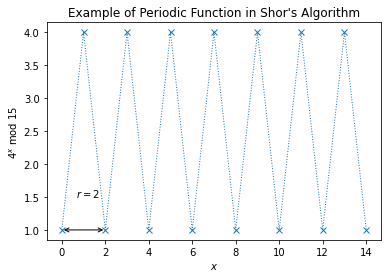

In [ ]:
#@title Example periodic function
N = 15
a = 4

# Calculate the plotting data
xvals = np.arange(15)
yvals = [np.mod(a**x, N) for x in xvals]

# Use matplotlib to display it nicely
fig, ax = plt.subplots()
ax.plot(xvals, yvals, linewidth=1, linestyle='dotted', marker='x')
ax.set(xlabel='$x$', ylabel=f'${a}^x$ mod ${N}$',
       title="Example of Periodic Function in Shor's Algorithm")
try: # plot r on the graph
    r = yvals[1:].index(1) + 1
    plt.annotate('', xy=(0,1), xytext=(r,1),
                 arrowprops=dict(arrowstyle='<->'))
    plt.annotate(f'$r={r}$', xy=(r/3,1.5))
except ValueError:
    print('Could not find period, check a < N and have no common factors.')

In [ ]:
for j in range(16):
    print("|", j, "⟩", "|",(4**j) % 15, "⟩")

| 0 ⟩ | 1 ⟩
| 1 ⟩ | 4 ⟩
| 2 ⟩ | 1 ⟩
| 3 ⟩ | 4 ⟩
| 4 ⟩ | 1 ⟩
| 5 ⟩ | 4 ⟩
| 6 ⟩ | 1 ⟩
| 7 ⟩ | 4 ⟩
| 8 ⟩ | 1 ⟩
| 9 ⟩ | 4 ⟩
| 10 ⟩ | 1 ⟩
| 11 ⟩ | 4 ⟩
| 12 ⟩ | 1 ⟩
| 13 ⟩ | 4 ⟩
| 14 ⟩ | 1 ⟩
| 15 ⟩ | 4 ⟩


The left column represents the first register and the right one the second register for our example. You can observe that the values for the function, where $a=4$ oscillates between $1$ and $4$.

**Step 4: Principles of implicit measurement**

> "Without loss of generality, any unterminated quantum wires (qubits which are not measured) at the end of a quantum circuit may be assumed to be measured." [1]

Since we don't use the second register anymore, we can assume that we measure it. In this case, if we would measure the second register, then we would either get $1$ or $4$ with equal probability.

Suppose we measure the value $4$, which will result in:
$$\frac{1}{\sqrt{8}}\Big[|1⟩+|3⟩+|5⟩+|7⟩+|9⟩+|11⟩+|13⟩+|15⟩\Big]\otimes |4⟩$$

Therefore only the qubits of the first register for which the second register has the value $4$ are left. Note also that the normalization term changes since we don't consider half of the qubits anymore. For the next steps, we will only use the first register and we will not consider the second register anymore.

**Step 5: Inverse Quantum Fourier Transform**

In step 5 we apply the inverse QFT on the first register. <br>

$$QFT^{†}|\bar{u}⟩=|u⟩=\frac{1}{\sqrt{L}}\sum_{j=0}^{L-1}e^{\frac{-2\pi i}{L}uj}|j⟩$$
The $†$ denotes the complex conjugate transpose.

Calculation of the respective outcomes:

$$QFT^{†}|\bar{u}⟩=\frac{1}{\sqrt{16}\sqrt{8}}\sum_{j=0}^{15}\Big[e^{\frac{-\pi i}{8}j} + e^{\frac{-3\pi i}{8}j}+^{\frac{-5\pi i}{8}j}+^{\frac{-7\pi i}{8}j}+^{\frac{-9\pi i}{8}j}+^{\frac{-11\pi i}{8}j}+^{\frac{-13\pi i}{8}j}+^{\frac{-15\pi i}{8}j}\Big]$$

0 (8+0j)
8 (-8-0j)


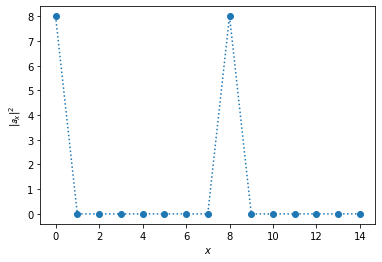

In [ ]:
import math

l = 4
u = [1,3,5,7,9,11,13,15]
def qtf_dagger(l, u):
    L = 2**l

    x = np.arange(L-1)

    normalization = 1/(math.sqrt(L)*(math.sqrt(len(u))))

    values = []


    for j in x:
        sum = 0
        for u_dash in u:

            sum += np.exp((-2 * math.pi * 1j * u_dash * j)/(L))
        values.append(abs(sum))
        if abs(sum) > 1e-10:
            print(j, np.round(sum))

    plt.plot(x, values, 'o:')
    plt.xlabel("$k$")
    plt.ylabel("$|\mathcal{a}_k|^2$")


qtf_dagger(l, u)


Due to inference, the states $|0⟩$ and $|8⟩$ are left, since the sums for the other $j$ values vanish. The values peak for which $s = k\frac{r}{L}$ is an integer.<br>

$$QFT^{†}|\bar{u}⟩=\frac{1}{\sqrt{16}\sqrt{8}}\sum_{j=0}^{15}\Big[e^{\frac{-\pi i}{8}j} + e^{\frac{-3\pi i}{8}j}+\ldots+^{\frac{-15\pi i}{8}j}\Big]=\frac{1}{\sqrt{16}\sqrt{8}}\Big[8|0⟩-8|8⟩\Big]$$

**Step 6: Measurement of the first register**

Measuring the first register gives us either the state $|0⟩$ or $|8⟩$ with equal probability.

**Step 7: Finding $r$ and calculate the factors of $N$**

Now the quantum part is finished and we can continue with a classical computer since there exist efficient algorithms for the remaining steps, like the continued fractions algorithm. We will not go into detail about how these algorithms function, since that is not the scope of this project.

$|0⟩$: <br>
$$k\frac{r}{16}=0$$
If we measure the state $|0⟩$, we have to repeat the procedure until we measure a state, which is not $|0⟩$, since if $k=0$ we can't find a solution of $r$.<br><br>
$|8⟩$:
$$k\frac{r}{16}=8$$

One solution would be that $k=1$ and $r=2$:

As you might remember from the second theorem, we have to check if $r$ is equal. Since $r=8$, this is fulfilled. <br>
We have to solve the following equation:
$$x=4^{\frac{2}{2}}\textrm{ (mod 15)} $$


In [ ]:
x = 4%15

The result for $x$ is $4$ and therefore we need to calculate gcd($3$, $N$) and gcd($5$, $N$).

In [ ]:
a = x + 1
b = x - 1
N = 15
print("Potential factor: ",math.gcd(a, N))
print("Potential factor: ",math.gcd(b, N))

Potential factor:  5
Potential factor:  3


We found the factors of $N$ and therefore applied Shor's Algorithm successfully.

It is important to note that the use of Shor's Algorithm to factor large integers requires a quantum computer with a significant number of qubits and gates, which are currently not available. As a result, RSA continues to provide sufficient security. However, as quantum computing technology advances, it is possible that Shor's Algorithm leads to new challenges in the field of cryptography.

**References**:

[1] Michael A. Nielsen and Isaac L. Chuang. 2011. Quantum Computation and Quantum Information: 10th Anniversary Edition (10th. ed.). Cambridge University Press, USA. <br>
[2] Abraham Asfaw (14.12.2022). 12. Shor's algorithm II: From Factoring to Period-Finding, Writing the Quantum Program - Part 3. Retrieved from https://youtu.be/IFmkzWF-S2k. <br>
[3] IBM (n.d.). Shor's Algorithm. Qiskit-Textbook. Retrieved December 14, 2022, from https://learn.qiskit.org/course/ch-algorithms/shors-algorithm. <br>
[4] De Wolf, R. (2019). Quantum computing: Lecture notes. arXiv preprint arXiv:1907.09415. <br>
[5] Rabl, P. (2022). Course: 8.3581 How does a quantum computer work?, ShorsAlgorithm. <br>
[6] Ireland, D. (updated 2021, June 1). RSA algorithm. Retrieved December 18, 2022, from https://www.di-mgt.com.au/rsa_alg.html

